# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}/tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
#arch=resnet34
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty ResNext50 model.
First we compute the mean and standard deviation of all images to center them.
## Computing mean and stddev

In [5]:

import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

Input images number :  1310


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [1.54975 1.51391 1.60444]
Means with PIL :  [0.53286 0.5643  0.59667]


### Prepare data an model

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)

In [7]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

The model is realy deep as it make use of 168 layers.

How much input data do we get ?

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

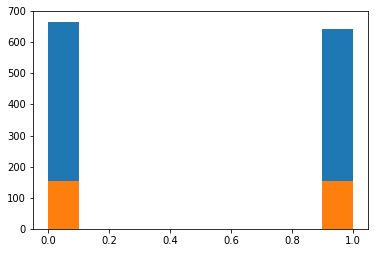

In [8]:
# This is the label for a val data
plt.hist(data.trn_y)
plt.hist(data.val_y)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


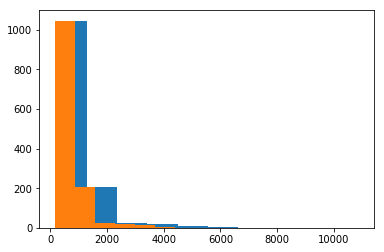

In [9]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

(array([ 23.,  51.,  49.,  74., 119., 179.,  77., 100.,  33.,  59.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

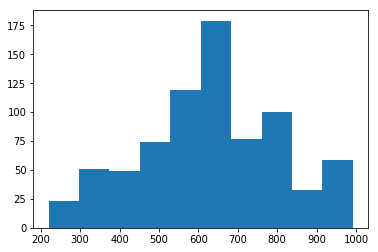

In [10]:
plt.hist(row_sz[row_sz < 1000])

We have few data

### Guess learning rate

 93%|█████████▎| 305/328 [00:15<00:01, 19.69it/s, loss=2.55] 

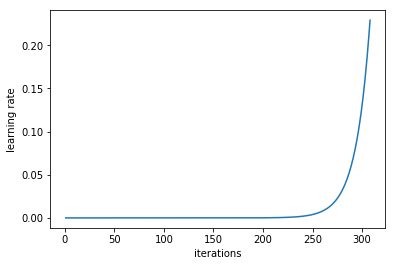

In [11]:
lrf=learn.lr_find(1e-10, end_lr=1)
learn.sched.plot_lr()

In [12]:
#?learn.lr_find

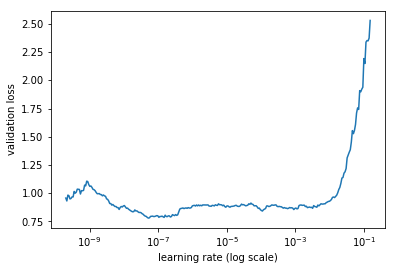

In [13]:
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                    
    0      0.792255   0.708602   0.483871  
    1      0.773341   0.708075   0.46129                     
    2      0.763015   0.684855   0.535484                    
    3      0.740599   0.689016   0.516129                    
    4      0.73913    0.69652    0.5                         
    5      0.72872    0.694311   0.503226                    
    6      0.741457   0.693228   0.516129                    
    7      0.716415   0.688391   0.525806                    
    8      0.717405   0.690171   0.535484                    
    9      0.708162   0.692242   0.487097                    
    10     0.71613    0.688954   0.512903                    
    11     0.704154   0.692402   0.5                         
    12     0.705415   0.698851   0.480645                    
    13     0.709144   0.693807   0.506452                    
    14     0.706624   0.692166   0.506452                    
    15     0.699652   0.69

array([[155,   0],
       [155,   0]])

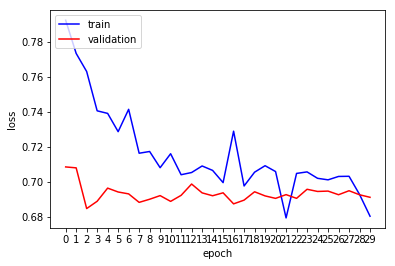

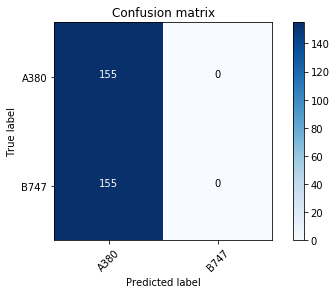

In [14]:
#F2 :  0.02 for lr=1e-3, image_size=128, batch_size=256, epoch=30 # very erratic graph
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=256, epoch=30
#F2 :  0.11 for lr=1e-5, image_size=128, batch_size=256, epoch=30


lr=1e-4
image_size=128
batch_size=128
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [15]:
#learn.sched.plot_loss()

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

epoch      trn_loss   val_loss   accuracy                
    0      0.805125   0.701522   0.612903  
    1      0.676221   0.816822   0.683871                
    2      0.536968   0.922364   0.732258                
    3      0.424079   0.789079   0.754839                
    4      0.334268   0.619325   0.780645                
    5      0.26885    0.553034   0.829032                
    6      0.217196   0.594767   0.825806                
    7      0.175488   0.577676   0.83871                 
    8      0.146099   0.635276   0.829032                
    9      0.121456   0.627885   0.83871                 
    10     0.101569   0.612273   0.819355                
    11     0.085588   0.634436   0.835484                 
    12     0.072835   0.668774   0.809677                 
    13     0.062785   0.653994   0.822581                 
    14     0.053258   0.667104   0.822581                 
    15     0.045373   0.640254   0.825806                 
    16     0.038284   0

array([[133,  22],
       [ 28, 127]])

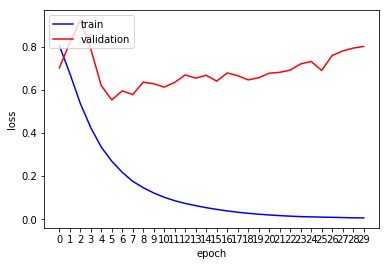

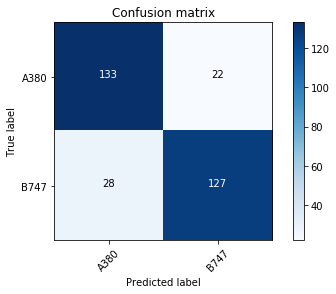

In [16]:
!rm -r {PATH}/tmp
    # F2 :  0.78 for image_size=128, batch_size=150, lr=1e-3, epoch=30
    # F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2, epoch=30
    # F2 :  0.77 for image_size=128, batch_size=150, lr=1e-4, epoch=30
    # F2 :  0.80 for image_size=128, batch_size=150, lr=1e-2, epoch=30
#F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2, epoch=30
# F2 :  0.80 for image_size=128, batch_size=150, lr=1e-3, epoch=30
# F2 :  0.76 for image_size=128, batch_size=150, lr=1e-4 # good graph


image_size=128
batch_size=150
lr=1e-2
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

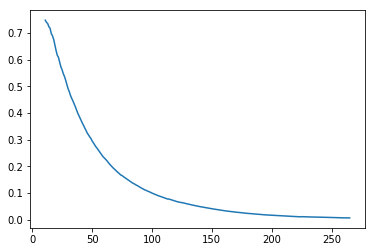

In [17]:
learn.sched.plot_loss()

## Data augmentation
Apply random operations on pictures to help the model to generalize.
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

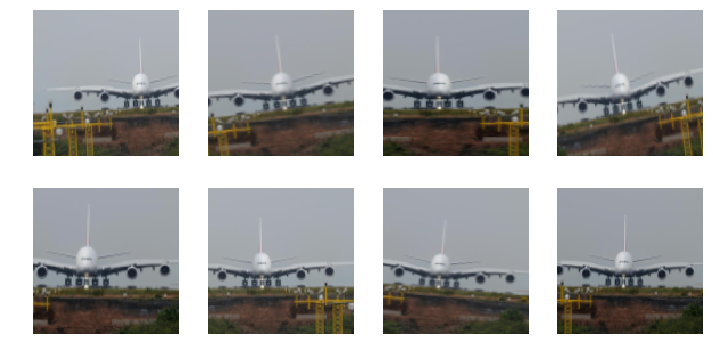

In [18]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)


def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.872452   1.636703   0.532258  
    1      0.787027   1.802879   0.587097                  
    2      0.724028   0.672625   0.674194                  
    3      0.653618   0.596688   0.729032                  
    4      0.60067    0.666131   0.696774                  
    5      0.543728   0.577337   0.73871                   
    6      0.497696   0.57312    0.770968                  
    7      0.47247    0.7291     0.696774                  
    8      0.422547   0.641466   0.774194                  
    9      0.366428   0.680755   0.783871                  
    10     0.30977    0.764434   0.735484                  
    11     0.275762   0.635302   0.774194                  
    12     0.249292   0.626074   0.793548                  
    13     0.218333   0.736534   0.76129                   
    14     0.201332   0.713731   0.764516                  
    15     0.201396   0.722831   0.719355               

array([[139,  16],
       [ 47, 108]])

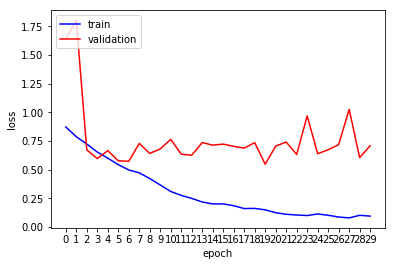

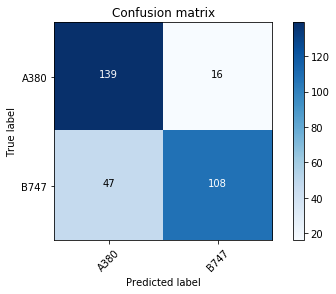

In [19]:
!rm -r {PATH}/tmp
    # F2 :  0.84 for image_size=128, batch_size=150, lr=1e-3, epoch=30, ps=0.5
    # F2 :  0.73 for image_size=128, batch_size=150, lr=0.0001, epoch=30, ps=0.5
    # F2 :  0.79 for image_size=128, batch_size=128, lr=1e-4, epoch=30
    # F2 :  0.86 for image_size=128, batch_size=128, lr=1e-3, epoch=30
# F2 :  0.83 for image_size=128, batch_size=128, lr=1e-3, epoch=30
# F2 :  0.75 for image_size=128, batch_size=256, lr=1e-4, epoch=30
# F2 :  0.81 for image_size=128, batch_size=64, lr=1e-4 # good graph


image_size=128
batch_size=64
lr=1e-2
epoch=30

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

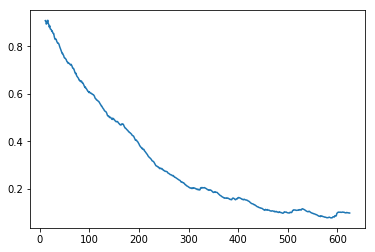

In [20]:
learn.sched.plot_loss()

## Multiple size

epoch      trn_loss   val_loss   accuracy                
    0      0.869393   0.7572     0.541935  
After  1  epochs, the accuracy is  54.19 %
Saving to  resnext50_1_300_acc54.19_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.680821   0.634022   0.641935  
    1      0.638869   0.621987   0.709677                
    2      0.57285    0.59762    0.741935                
    3      0.518936   0.552414   0.76129                 
    4      0.468058   0.553591   0.770968                
    5      0.425506   0.541864   0.787097                
    6      0.392806   0.5066     0.787097                
    7      0.352308   0.50919    0.8                     
    8      0.3182     0.535936   0.793548                
    9      0.282199   0.539338   0.790323                
After  11  epochs, the accuracy is  79.03 %
Saving to  resnext50_11_64_acc79.03_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.144501   0.539075   0.790323  
    1      0.138394   0.553448   0.787097                
    2      0.132142   0.543932   0.8                     
    3      0.12067    0.547019   0.803226                
    4      0.115814   0.573513   0.825806                
    5      0.106794   0.581959   0.8                     
    6      0.099243   0.584051   0.803226                 
    7      0.091563   0.580481   0.816129                 
    8      0.081743   0.613031   0.816129                 
    9      0.074353   0.64341    0.812903                 
After  21  epochs, the accuracy is  81.29 %
Saving to  resnext50_21_128_acc81.29_weights


epoch      trn_loss   val_loss   accuracy                 
    0      0.042696   0.639744   0.803226  
    1      0.04334    0.651683   0.806452                 
    2      0.046662   0.664623   0.806452                 
    3      0.046322   0.616732   0.809677                 
    4      0.046031   0.635421   0.8                      
    5      0.045852   0.683912   0.793548                 
    6      0.042638   0.696481   0.793548                 
    7      0.043068   0.678506   0.8                      
    8      0.039219   0.688606   0.790323                 
After  30  epochs, the accuracy is  79.03 %
Saving to  resnext50_30_300_acc79.03_weights
[[131  24]                                   
 [ 29 126]]
Precision :  0.8451612903225807
Recall :  0.81875
F1 :  0.8317460317460317
F2 :  0.8238993710691824


array([[131,  24],
       [ 29, 126]])

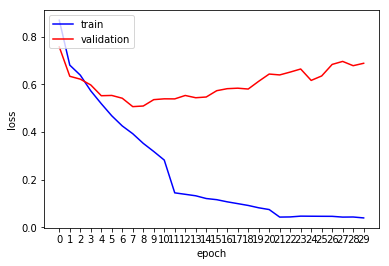

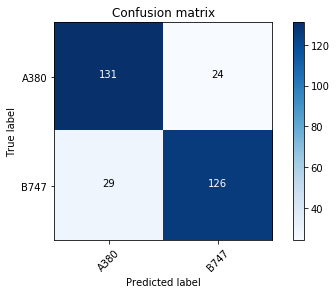

In [21]:
!rm -r {PATH}/tmp
    # F2 :  0.67 for learning_rate = 1e-4, dropout = [0.25,0.5], image_size = 128, batch_size = 150
    # F2 :  0.62 pour dropout =[0.25,0.5] et learning_rate = 1e-3
    # F2 :  0.79 pour dropout = 0.5 et learning_rate = 1e-3
    # F2 :  0.85 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
    # F2 :  0.86 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
#F2 :  0.83 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
# F2 :  0.61 for learning_rate = 1e-4, dropout = 0.5, image_size = 128, batch_size = 150 # bad graph


learning_rate = 1e-2
dropout = [0.25,0.5]
image_size = 128
batch_size = 150

global_results = collections.OrderedDict([])
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 9],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

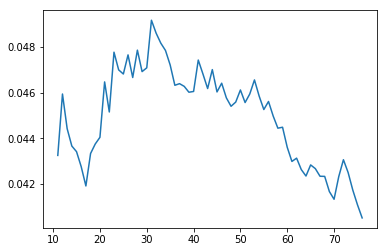

In [22]:
learn.sched.plot_loss()

## SGDR - Learning rate anealing

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

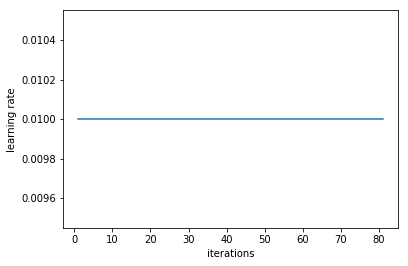

In [23]:
learn.sched.plot_lr()

Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.717889   0.553474   0.729032  
After  1  epochs, the accuracy is  72.90 %
Saving to  resnext50_1_300_acc72.90_weights
Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.562554   0.458104   0.774194  
    1      0.441391   0.411585   0.809677                    
    2      0.395459   0.360561   0.858065                    
    3      0.36568    0.314819   0.864516                    
    4      0.322078   0.266273   0.887097                    
    5      0.258541   0.334959   0.864516                    
    6      0.241373   0.27682    0.874194                    
    7      0.256236   0.229566   0.887097                    
    8      0.175829   0.23118    0.906452                    
    9      0.225263   0.29366    0.867742                    
After  11  epochs, the accuracy is  86.77 %
Saving to  resnext50_11_64_acc86.77_weights
Hyperparameters : Batch size= 150  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.161924   0.223792   0.912903  
    1      0.170427   0.23549    0.893548                    
    2      0.174622   0.26052    0.9                         
    3      0.146769   0.234228   0.912903                    
    4      0.129685   0.219268   0.916129                    
    5      0.137014   0.187026   0.925806                    
    6      0.17415    0.175051   0.932258                    
    7      0.163154   0.211819   0.919355                    
    8      0.110821   0.240291   0.922581                     
    9      0.102782   0.161956   0.941935                     
After  21  epochs, the accuracy is  94.19 %
Saving to  resnext50_21_128_acc94.19_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.160817   0.224758   0.922581  
    1      0.143725   0.232267   0.919355                    
    2      0.107748   0.16077    0.935484                     
    3      0.154073   0.24092    0.922581                     
    4      0.108091   0.15147    0.93871                      
    5      0.124318   0.173258   0.93871                      
    6      0.116362   0.161691   0.932258                    
    7      0.11605    0.169962   0.93871                      
    8      0.139981   0.216188   0.925806                    
    9      0.138289   0.174223   0.945161                    
After  31  epochs, the accuracy is  94.51 %
Saving to  resnext50_31_300_acc94.51_weights


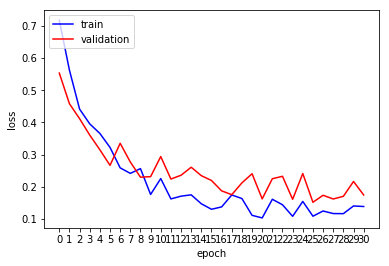

In [24]:
!rm -r {PATH}/tmp
    # F2 :  0.80 pour [0.25,0.5] et 1e-4
    # F2 :  0.76 pour dropout = 0.5 et learning_rate = 1e-4
    # F2 :  0.76  for learning_rate = 1e-3, dropout = [0.25,0.5], lr=np.array([learning_rate/100,learning_rate/10,learning_rate]
    # F2 :  0.49 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5] 
    # F2 :  0.74 for learning_rate = 1e-4, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5] 
    # F2 :  0.53 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5]
# F2 :  0.81 for learning_rate = 1e-4, lr=np.array([learning_rate/100,learning_rate/10,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.91 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # good graph


learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = [0.25,0.5] 


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]
#    [256, 128, 3],
#    [123, 300, 3],
#    [64, 600, 3],
#    [123, 300, 4],
#    [256, 128, 2],
#    [123, 300, 2],
#    [64, 600, 3],
#    [123, 400, 2]
for bs, sz, epoch in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)


[[150   5]                                   
 [ 11 144]]
Precision :  0.967741935483871
Recall :  0.9316770186335404
F1 :  0.949367088607595
F2 :  0.9386733416770964


array([[150,   5],
       [ 11, 144]])

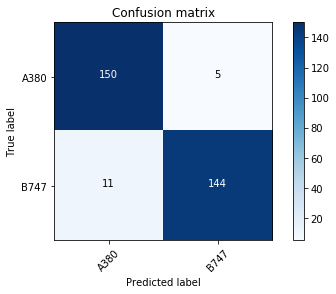

In [25]:
plot_the_confusion_matrix()

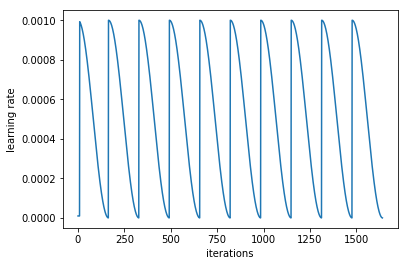

In [26]:
learn.sched.plot_lr()

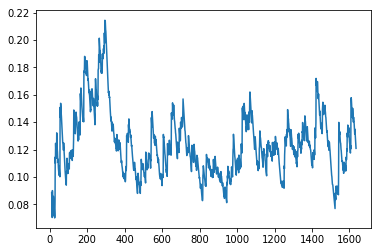

In [27]:
learn.sched.plot_loss()

## Variable cycle length

In [28]:
!rm -r {PATH}/tmp

learning_rate = 1e-2
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = 0.5 #[0.25,0.5]
    # F2 :  0.66 pour learning_rate = 1e-3 et dropout = [0.25,0.5]
    # F2 :  0.85 for learning_rate = 1e-3, dropout = [0.25,0.5]
    # F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.96 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.92 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 3],
    [512, 64, 4],
    [256, 128, 3],
    [123, 400, 4]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)


Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.01  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                   
    0      1.096101   0.747762   0.506452  
    1      1.476223   1.227206   0.519355                   
    2      0.926953   0.789959   0.593548                    
    3      1.075875   1.34254    0.554839                   
    4      0.880067   0.821545   0.606452                    
    5      0.670112   0.639962   0.680645                    
    6      0.58153    0.606123   0.687097                    
After  7  epochs, the accuracy is  68.70 %
Saving to  resnext50_7_300_acc68.70_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.01  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.661163   0.58055    0.696774  
    1      0.771918   0.609297   0.716129                    
    2      0.55512    0.648044   0.7                         
    3      0.687589   0.55643    0.745161                    
    4      0.52217    0.509114   0.748387                    
    5      0.423167   0.462057   0.774194                    
    6      0.38292    0.475819   0.770968                    
    7      0.543905   0.819814   0.635484                    
    8      0.528173   0.425094   0.8                         
    9      0.414711   0.607551   0.767742                    
    10     0.345537   0.484239   0.825806                    
    11     0.315573   0.36844    0.825806                    
    12     0.298341   0.430058   0.796774                    
    13     0.23019    0.471833   0.819355                    
    14     0.244635   0.379768   0.832258                    
After  22  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.270476   0.348287   0.851613  
    1      0.311378   0.303125   0.870968                    
    2      0.225812   0.337851   0.86129                     
    3      0.26632    0.7889     0.777419                    
    4      0.203636   0.65366    0.777419                    
    5      0.234529   0.417327   0.86129                     
    6      0.170595   0.255516   0.903226                    
After  29  epochs, the accuracy is  90.32 %
Saving to  resnext50_29_128_acc90.32_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.01  Cycle= 4  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                    
    0      0.168733   0.318719   0.867742  
    1      0.257671   0.346227   0.896774                    
    2      0.189203   0.39196    0.864516                    
    3      0.177931   0.401076   0.825806                    
    4      0.175906   0.429348   0.851613                    
    5      0.147363   0.314621   0.874194                    
    6      0.170263   0.331549   0.864516                    
    7      0.219051   0.351346   0.854839                    
    8      0.228503   0.459795   0.854839                    
    9      0.229234   0.651593   0.835484                    
    10     0.161579   0.310949   0.870968                    
    11     0.180696   0.34096    0.864516                    
    12     0.111535   0.285853   0.9                         
    13     0.122995   0.296902   0.887097                     
    14     0.132273   0.569632   0.854839                    
After  44  epochs, the ac

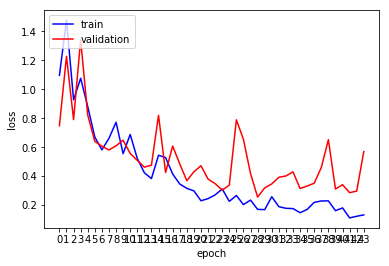

In [29]:
#plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)


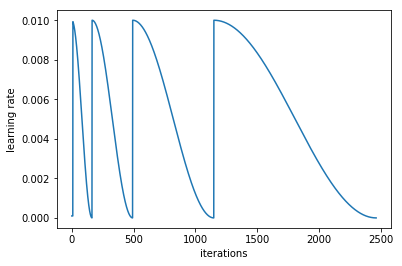

In [30]:
learn.sched.plot_lr()

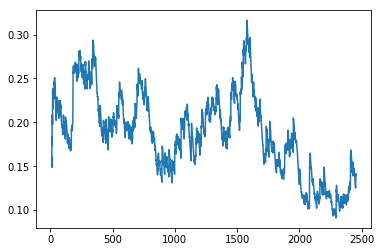

In [31]:
learn.sched.plot_loss()

[[144  11]                                   
 [ 26 129]]
Precision :  0.9290322580645162
Recall :  0.8470588235294118
F1 :  0.8861538461538462
F2 :  0.8622754491017964


array([[144,  11],
       [ 26, 129]])

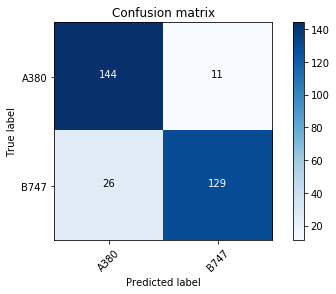

In [32]:
plot_the_confusion_matrix()

# More epochs

In [33]:
!rm -r {PATH}/tmp
# resnext50 results :

# resnet34 result :
    # F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]

learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = [0.25,0.5]
#arch=resnet34
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 4],
    [256, 128, 4],
    [123, 300, 5],
    [64, 600, 5]
    
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3]
#     [123, 400, 6]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters for ", arch.__name__, " : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)



Hyperparameters for  resnext50  : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.757644   0.572294   0.725806  
After  1  epochs, the accuracy is  72.58 %
Saving to  resnext50_1_300_acc72.58_weights
Hyperparameters for  resnext50  : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.575153   0.466402   0.754839  
    1      0.446975   0.3776     0.854839                    
    2      0.382486   0.352092   0.864516                    
    3      0.396746   0.307748   0.870968                    
    4      0.303143   0.286599   0.880645                    
    5      0.293628   0.311273   0.851613                    
    6      0.228546   0.304688   0.874194                    
    7      0.245163   0.332933   0.874194                    
    8      0.210742   0.310567   0.887097                    
    9      0.213289   0.306256   0.854839                    
    10     0.157032   0.276962   0.890323                    
    11     0.145323   0.264043   0.9                         
    12     0.154274   0.25545    0.887097                    
    13     0.161399   0.259758   0.896774                    
    14     0.153283   0.257344   0.883871                    
After  16  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.134095   0.296882   0.877419  
    1      0.138769   0.291526   0.890323                    
    2      0.131049   0.268973   0.893548                     
    3      0.168695   0.305565   0.903226                    
    4      0.128788   0.253332   0.903226                    
    5      0.106109   0.261786   0.896774                    
    6      0.106737   0.277309   0.883871                    
    7      0.125119   0.310873   0.883871                     
    8      0.137148   0.274787   0.883871                    
    9      0.117141   0.299017   0.854839                    
    10     0.084122   0.235344   0.887097                     
    11     0.086357   0.216852   0.909677                     
    12     0.088968   0.24571    0.890323                     
    13     0.091531   0.229753   0.903226                     
    14     0.10414    0.23083    0.906452                     
After  31  epochs, 

epoch      trn_loss   val_loss   accuracy                     
    0      0.075976   0.228162   0.912903  
    1      0.122755   0.248622   0.906452                     
    2      0.091682   0.223823   0.912903                     
    3      0.077803   0.246907   0.909677                     
    4      0.135825   0.256765   0.887097                    
    5      0.073485   0.260017   0.880645                     
    6      0.11125    0.233409   0.893548                     
    7      0.138606   0.258545   0.896774                    
    8      0.135996   0.2081     0.916129                    
    9      0.105072   0.208489   0.919355                     
    10     0.093359   0.234072   0.906452                     
    11     0.098471   0.20075    0.912903                     
    12     0.082312   0.213774   0.912903                     
    13     0.083189   0.197351   0.912903                     
    14     0.071014   0.201232   0.916129                     
    15     0.1

epoch      trn_loss   val_loss   accuracy                     
    0      0.069057   0.198359   0.912903  
    1      0.05805    0.192363   0.932258                     
    2      0.097172   0.246033   0.903226                     
    3      0.080063   0.237539   0.906452                     
    4      0.087458   0.160253   0.935484                     
    5      0.071421   0.155257   0.945161                     
    6      0.103946   0.177356   0.93871                      
    7      0.106955   0.180286   0.93871                      
    8      0.098694   0.219336   0.916129                     
    9      0.055401   0.169843   0.93871                      
    10     0.068702   0.178905   0.945161                     
    11     0.069571   0.172555   0.93871                      
    12     0.059972   0.1645     0.945161                     
    13     0.067441   0.157703   0.935484                     
    14     0.047249   0.158833   0.941935                     
    15     

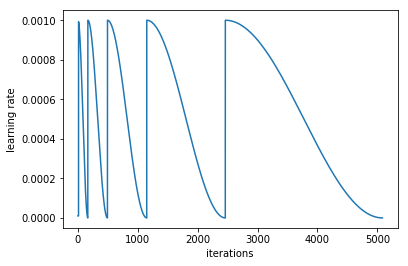

In [34]:
learn.sched.plot_lr()

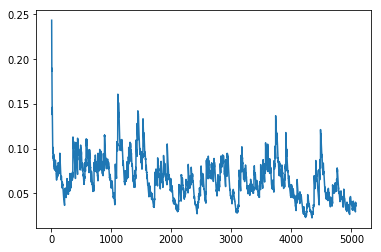

In [35]:
learn.sched.plot_loss()

<Figure size 1120x640 with 0 Axes>

[[147   8]                                   
 [  6 149]]
Precision :  0.9483870967741935
Recall :  0.9607843137254902
F1 :  0.9545454545454546
F2 :  0.9582790091264669


array([[147,   8],
       [  6, 149]])

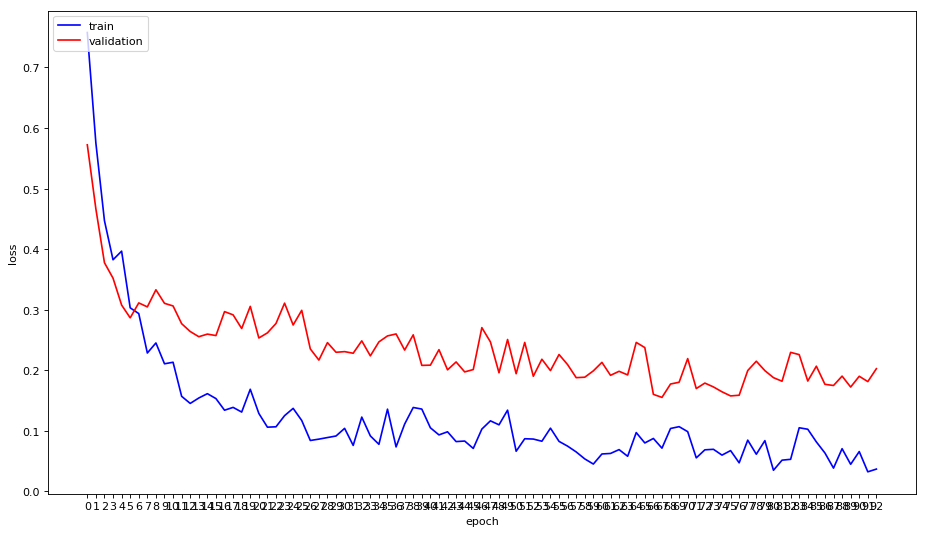

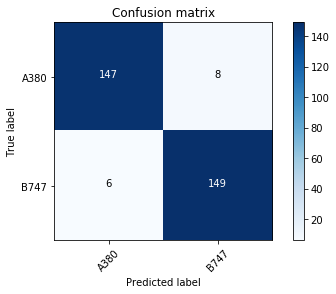

In [36]:

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [37]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, 64), bs=123, num_workers=num_cpus())
    data = get_data(64, 64) 
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
    learn.load("resnext50_32_400_acc95.01_weights")
    learn.freeze()
    vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    plot_ep_vals(global_results)
    print("Model chargé")

# Prediction et visualisation

[[148   7]                                   
 [  8 147]]
Precision :  0.9548387096774194
Recall :  0.9487179487179487
F1 :  0.9517684887459806
F2 :  0.949935815147625


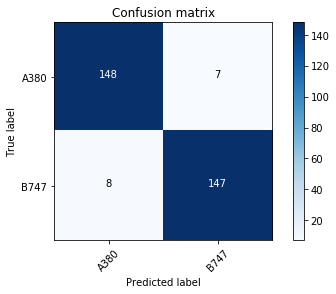

In [38]:
cm = plot_the_confusion_matrix()

In [39]:
#?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [40]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9548387096774194
recall :  0.9487179487179487
F1 :  0.9517684887459806
F2 :  0.949935815147625


In [43]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 6

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['A380', 'B747']

(310, 2)

Most incorrect A380


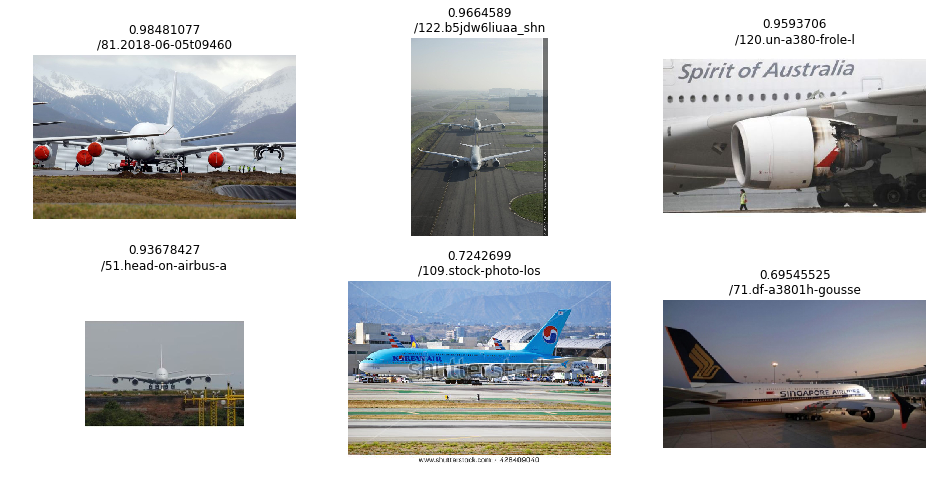

In [44]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect B747


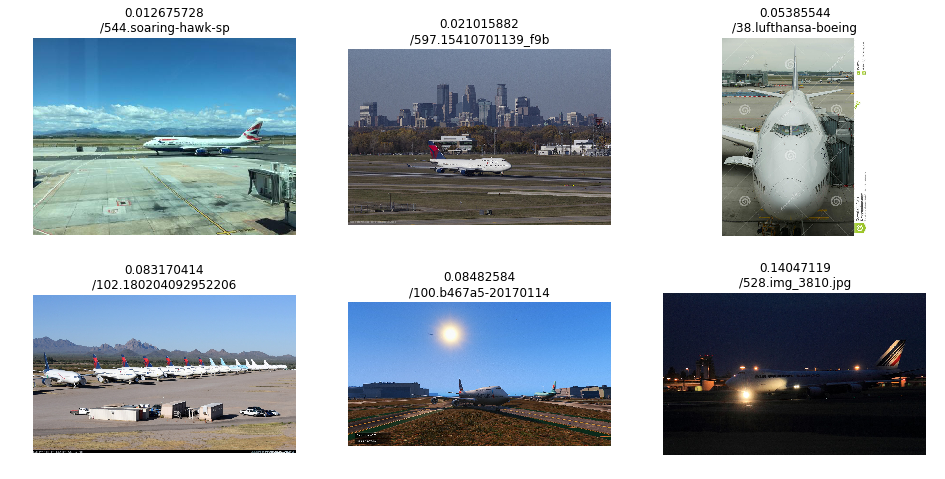

In [45]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


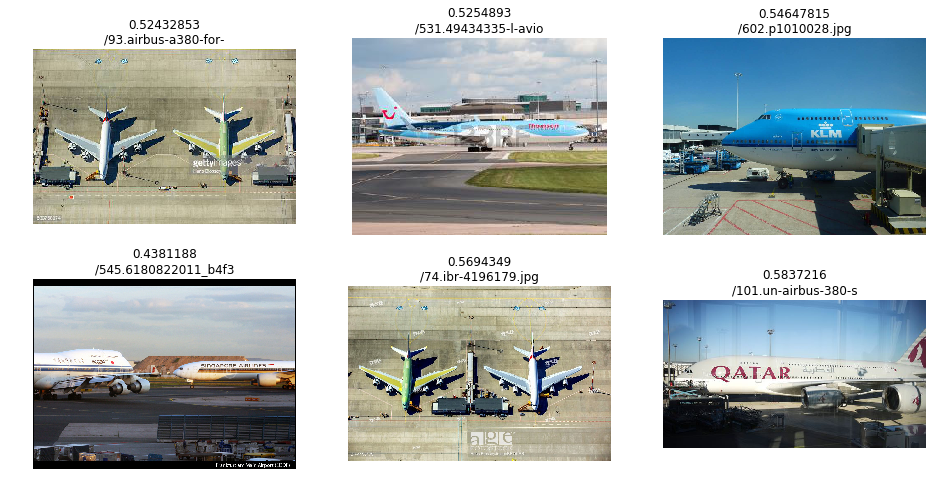

In [46]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct B747


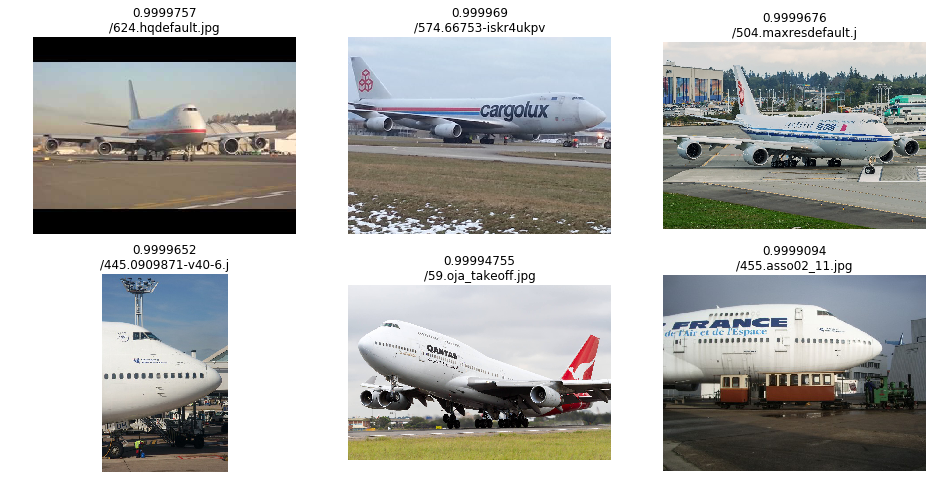

In [47]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct A380


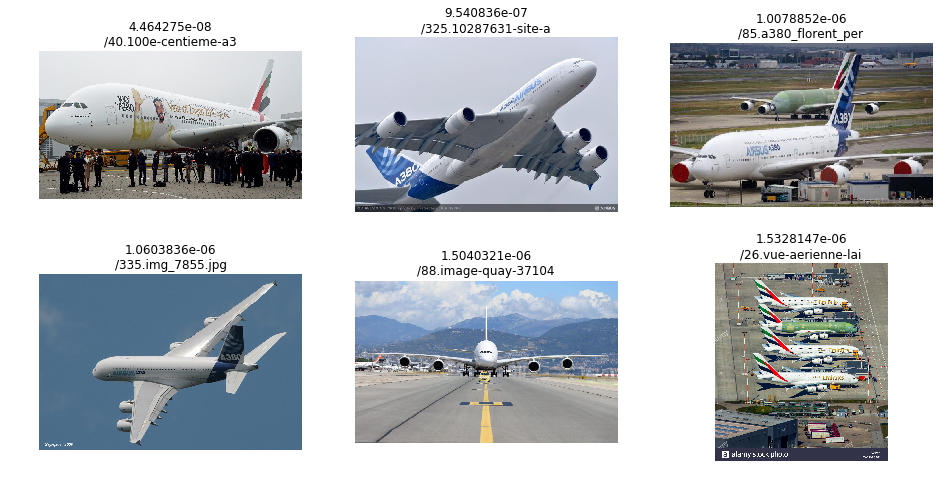

In [48]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.